# 模型的选择

- 训练误差：模型在训练数据上的误差
- 泛化误差：模型在新数据上的误差

**关心泛化误差**

将数据集分为：

- 训练数据集：用来训练网络参数
- 验证数据集：**不参与训练**
    - 验证数据集是用来调超参数的
    - 一般通过分割数据集得到
- 测试数据集：**只能使用一次**
    - 不能用来调超参数
    - 甚至没有label


## 没有足够多的数据

**K-折交叉验证**

```
算法：
For i = 1,...,K
    将第i块作为验证数据集，其余作为训练数据集
报告K个验证集误差的平均值

一般K=5或者10
```

- 确定某一个超参数
- 选择k个中最好的超参数
- k个模型全部都要，取均值

# 过拟合和欠拟合

|模型容量|简单|复杂|
-|-|-
|低|正常|欠拟合|
|高|过拟合|正常|

**根据数据的复杂度选择合适的模型容量**

**模型容量**
- 拟合函数的能力
- 低容量的模型难以拟合训练数据
- 高容量的模型可以*记住所有的训练数据*

> 随着模型容量的增加，训练误差减小，泛化误差先减小，后增大

**估计模型容量**

- 难以比较不同种类算法之间的模型容量
    - Eg.树模型(随机森林)和神经网络
- 给定一个种类的模型
    - 参数个数
        - 线性模型 d 个输入，一个输出：
            - $d+1$   (1是偏移量)
        - 单隐藏层 d个输入，m个隐藏层，k个输出
            - $(d+1)m+(m+1)k$
    - 参数值的选择范围

**VC 维**

- 统计学习理论的核心思想
- 对于一个分类模型，VC等于最大的一个数据集大小，不管如何给定标号，都存在一个模型能够分类

线性分类：
- 2维输入感知机，VC维等于3：可以分类任何三个点，但不能是四个(XOR)
- N维输入感知机，VC维定于N+1
- 多层感知机的VC维：$N\log_2(N)$

**缺陷**：

- 提供了良好的理论依据
    - 可以用来训练误差和泛化误差之间的间隔
- 但深度学习中很少使用
    - 衡量不是很准确
    - 深度学习计算VC困难

**数据复杂度**

- 样本个数
- 每个样本的元素个数
- 时间、空间结构
- 多样性

# QA

**SVM 神经网络**

SVM 数据点多的时候，难以计算，可调性差

神经网络的优点：

- 是一门语言，可以通过编程，模仿世界，可编程好
- 可以做到很大的数据集
- 神经网络可以同时在训练的同时进行特征提取

**数据集常用分割**：

- 训练数据集：70%
    - 5折交叉验证 **深度学习，样本量大，一般不用**
- 验证数据集：30%

> 数据多，可以55开

**超参数的设计**

- 如何设计超参数 **靠经验**
- 如何选择 **自己调或者随机**

> Google 方法，k折时每次重新随机生成参数

**二分类中不平衡 1:9**

- 权重？最简单的方法 把1复制9遍
- 验证数据集要尽量1：1

**神经网络**：50% 艺术 + 50% 工程 (艺术+工程+科学)

**理论上mlp可以拟合所有函数，但是难以收敛，而神经网络通过描述可能的结构，使得其容易收敛**

In [1]:
%matplotlib inline
import math
import torch
import time
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [2]:
""" 函数复用 """
""" 累加器对象 """
class Accumulator: # 累加器对象
    """ 在 n 个变量上累加 """
    def __init__(self, n):
        self.data = [0.0] * n # python 语法 [0]*n将n个list连接在一起

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        # zip() 将迭代器打包成元组

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, index):
        return self.data[index]

""" 与真实值对比 """
def accuracy(y_hat, y):
    """ 分类问题，统计正确个数 """
    # y_hat 是二维矩阵，取每一行的最大值
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值对应的序号
    cmp = y_hat.type(y.dtype) == y # 保证 y 和 y_hat 类型相同
    # cmp 是 bool 类型
    return float(cmp.type(y.dtype).sum())

""" 评估 net 的准确性 """
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() # 如果是 torch 神经网络，则设置为评估模式，不进行反向传播
    accum = Accumulator(2)
    for X, y in data_iter:
        accum.add(accuracy(net(X), y), y.numel())
    return accum[0] / accum[1]

""" 一轮训练 """
def train_epoch_ch3(net, train_iter, loss, params, updater, lr):
    if isinstance(net, torch.nn.Module):
        net.train() # 训练模式，进行反向传播
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(params, lr, len(X)) # 更新器需要 batch_size
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

""" 训练函数 """
def train_ch3(net, train_iter, test_iter, loss, num_epochs, params, updater, lr):
    accumulator = [Accumulator(3) for _ in range(num_epochs)]
    for epoch in range(num_epochs):
        start = time.perf_counter()
        train_metrics = train_epoch_ch3(net, train_iter, loss, params, updater, lr) # 训练误差
        test_accuracy = evaluate_accuracy(net, test_iter) # 测试误差
        accumulator[epoch].add(train_metrics[0], train_metrics[1], test_accuracy)
        end = time.perf_counter()
        print(f"Finish {epoch + 1} train, cose {end-start:.3f} sec")
    return accumulator

def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.normal_(m.weight, mean=0, std=0.1)

""" 转换为tensor """
def load_arrays(data_array, batch_size, is_train=False):
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(*data_array), 
        batch_size=batch_size, shuffle=is_train)

$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [97]:
# 数据维度
max_degree = 20
# 数据集大小
n_train, n_test = 100, 100
# 真值系数
true_w = np.zeros(max_degree,dtype=np.float32)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6],dtype=np.float32)

# 数据集输入
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
# 多项式参数
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
# 数据集输出
labels = np.dot(poly_features, true_w)
test_labels = np.copy(labels)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [98]:
# 转换为 tensor
true_w, features, poly_features, labels, test_labels = [torch.tensor(data=x, dtype=torch.float32) 
    for x in [true_w, features, poly_features, labels, test_labels]]

In [99]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [104]:
""" 训练函数 """
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = torch.nn.MSELoss(reduction="none")
    input_shape = train_features.shape[-1]
    net = torch.nn.Sequential(torch.nn.Linear(input_shape, 1, bias=False))
    net.apply(init_weights)
    batch_size = min(10, train_labels.shape[0])
    
    train_iter = load_arrays((train_features, train_labels.reshape(-1,1)), batch_size=batch_size, is_train=True)
    test_iter = load_arrays((test_features, test_labels.reshape(-1,1)), batch_size=batch_size, is_train=False)
    train, test = [], []
    trainer = torch.optim.SGD(net.parameters(), lr = 0.001)
    accumulator = [Accumulator(2) for _ in range(num_epochs // 20)]
    for epoch in range(num_epochs):
        train_epoch_ch3(net=net, train_iter=train_iter, loss=loss, updater=trainer, params=None, lr=None)
        if epoch == 0 or (epoch+1) % 20 == 0:
            train.append(evaluate_loss(net, train_iter, loss))
            test.append(evaluate_loss(net, test_iter, loss))
    
    """ 绘图 """
    backend_inline.set_matplotlib_formats('svg')
    plt.rcParams["figure.figsize"] = (3.5, 2.5)

        
    plt.semilogy(list(range(0, num_epochs+1,20)), train, 'm--')
    plt.semilogy(list(range(0, num_epochs+1,20)), test, 'r:')
    plt.legend(["train", "test"])
    plt.xlabel('epochs')
    plt.ylabel('percent')
    plt.title(f'softmax in {num_epochs} epochs')
    plt.grid(True)
    print(f"Weight:{net[0].weight.data.numpy()}")
    # .data 可以舍去 requires_grad，含有 requires_grad 的tensor不能numpy()
    # 可以 net[0].weight.detach().numpy()


Weight:[[ 4.992065   1.2047467 -3.3948894  5.608716 ]]


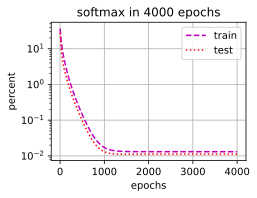

In [111]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:], num_epochs=4000) # 正常

Weight:[[3.728698  4.1576943]]


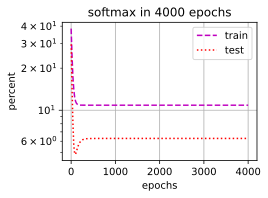

In [112]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:], num_epochs=4000) # 欠拟合

Weight:[[ 4.9649677   1.3959981  -3.1901913   4.7051992  -0.54490536  1.8284893
   0.09540202  0.45996645  0.01046851  0.10348983 -0.17090544  0.01832842
   0.0435547   0.08736427  0.06621262 -0.00777691 -0.11330572 -0.11748324
  -0.13545905  0.0068314 ]]


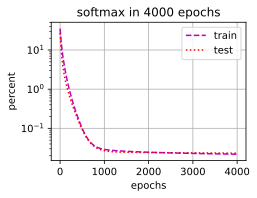

In [113]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=4000) # 过拟合